## Задача 3. Регуляризация

1. Сгенерируйте случайную малоранговую матрицу $X$ $500 \times 100$ ранга $10$
2. Сгенерируйте случайный вектор $w$ размера $100$ и целевой вектор 
$$
y = Xw + \varepsilon,
$$
где $\varepsilon$ - вектор с элементами из нормального распределения с нулевым средним и дисперсией $0.01$. 
3. Сравните разреженность и точность решения, которое дают методы регуляризации рассмотренные на лекции. Сделайте вывод об их эффективности. Рассмотрите, как автоматический подбор параметра регуляризации, так и эвристический подбор. Сравните эффективность методов. 
4. Проведите аналогичный эксперимент, но на данных, в которых целевой вектор сгенерирован так, что он хорошо аппроксимируется как одним признаком, так и линейной комбинацией двух или трёх других признаков. Выделяют ли методы регуляризации подобные зависимости в данных? Почему?
5. Добавьте в сгенерированную выборку несколько (5-10) выбросов, то есть таких строк и соответствующих им значений в $y$, что они не подчиняются ранее заданному закону.
6. Проверьте как изменится точность решения задачи для ранее рассмотренных методов
7. Сравните предыдущие методы регуляризации с [регуляризацией Huber'a](https://en.wikipedia.org/wiki/Huber_loss). Какой способ устойчивее к выбросам и почему?
8. Получите аналитическое решение задачи
$$
\min_w \|Xw - y\|^2_2 + \| \lambda \odot w \|^2_2,
$$
где $\lambda$ - вектор такой же размерности, что и $w$, $\odot$ означает поэлементное умножение двух векторов

Генерация случайной малоранговой матрицы $X$ $500\times100$ ранга 10

In [66]:
import numpy as np

def generateLowRankMatrix(rowsCount, columnCount, rank):
    matrix = np.zeros((rowsCount, columnCount))
    for i in range(rank):
        a = np.random.rand(rowsCount, 1)
        b = np.random.rand(1, columnCount)
        matrix = matrix + a.dot(b)
    return matrix

In [88]:
rowsCount = 500
columnCount = 100
rank = 10
matrix = generateLowRankMatrix(rowsCount, columnCount, rank)
# matrix_U = np.random.rand(rank, rowsCount)
# matrix_V = np.random.rand(rank, columnCount)
# matrix = matrix_U.T.dot(matrix_V)

Генерация случайного вектора $y = Xw + \varepsilon$

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import norm as normal_distribution
w = np.random.rand(columnCount, 1)

mean = 0
standartDeviation = 0.01
eps = np.random.normal(mean, standartDeviation, size = rowsCount)
epsr = eps.reshape(rowsCount, 1)

mw = matrix.dot(w)
y = matrix.dot(w) + epsr

Сравните разреженность и точность решения, которое дают методы регуляризации рассмотренные на лекции. Сделайте вывод об их эффективности. Рассмотрите, как автоматический подбор параметра регуляризации, так и эвристический подбор. Сравните эффективность методов.

In [114]:
modelNames = [ "Lasso", "Lasso CV", "Ridge", "Ridge CV", "ElasticNet", "ElasticNet CV", "Hubber" ]

In [117]:
from sklearn import linear_model as models
from numpy.linalg import norm
from IPython.display import HTML, display
import tabulate

def bold(s):
    return '<b>' + s + '</b>'

def modelStats(modelName, matrix, mw_c, y_c):
    mw = mw_c.ravel()
    y = y_c.ravel()
    
    #wtf no switch-case in python mdaa
    if modelName == "Lasso":
        model = models.Lasso(alpha = 1.0, max_iter = 10000)
    elif modelName == "Lasso CV":
        model = models.LassoCV(max_iter = 10000)
    elif modelName == "Ridge":
        model = models.Ridge(alpha = 1.0, max_iter = 10000)
    elif modelName == "Ridge CV":
        model = models.RidgeCV()
    elif modelName == "ElasticNet":
        model = models.ElasticNet(alpha=1.0, l1_ratio=0.1)
    elif modelName == "ElasticNet CV":
        model = models.ElasticNetCV()
    elif modelName == "Hubber":
        model = models.HuberRegressor()
        
    fit = model.fit(matrix, y)
    scoreNoise = fit.score(matrix, mw)
    score = fit.score(matrix, y)
    predict = norm(model.predict(matrix) - mw, 2)
    wNNZ = np.count_nonzero(model.coef_)
    return [bold(modelName), score, scoreNoise, predict, wNNZ]

def tableFullWidth(rawHTML):
    return '<style>table {width: 100%}</style>' + rawHTML

def tableStats(matrix, mw, y):
    table = [map(bold, ["Name", "Score (original)", "Score (with noise)", "||y_predict - y||", "wnnz"])]
    for name in modelNames:
        table.append(modelStats(name, matrix, mw, y))
    return HTML(tableFullWidth(tabulate.tabulate(table, tablefmt='html')))

display(tableStats(matrix, mw, y))

Name,Score (original),Score (with noise),||y_predict - y||,wnnz
Lasso,0.995060358161,0.995057929024,38.2828946601,7
Lasso CV,0.999997562831,0.999997668911,0.83143769747,12
Ridge,0.999999825298,0.999999981125,0.0748160342711,100
Ridge CV,0.999999837208,0.999999997473,0.0273729746743,100
ElasticNet,0.997541451345,0.997539683719,27.0113163628,100
ElasticNet CV,0.999985489567,0.999985441888,2.0777955429,77
Hubber,0.999999837235,0.999999998469,0.0213108250144,100


Some analysis.... todo

Добавьте в сгенерированную выборку несколько (5-10) выбросов, то есть таких строк и соответствующих им значений в  yy , что они не подчиняются ранее заданному закону.

In [147]:
modifications = 10

def addOutliers(mw, eps, n):
    eps2 = eps.copy()
    for i in range(n):
        yi = np.random.randint(rowsCount)
        r = np.random.chisquare(2, size = 1)[0]
        eps2[yi] += 100.0 * r
    epsr2 = eps2.reshape(rowsCount, 1)

    y = mw + epsr2
    return y

y2 = addOutliers(mw, eps, modifications)

Проверьте как изменится точность решения задачи для ранее рассмотренных  методов и сравните предыдущие методы регуляризации с регуляризацией Huber'a. Какой способ устойчивее к выбросам и почему?

In [148]:
print("Results table for 10 random outliers")
display(tableStats(matrix, mw, y2))

Results table for 10 random outliers


Name,Score (original),Score (with noise),||y_predict - y||,wnnz
Lasso,0.35718300975,0.953108963936,117.922096993,8
Lasso CV,0.358386537956,0.952143101339,119.130387588,8
Ridge,0.36149622793,0.936186283706,137.564792639,100
Ridge CV,0.361469474072,0.939039356097,134.454410238,100
ElasticNet,0.354162555661,0.965839988072,100.6489587,96
ElasticNet CV,0.35727881891,0.960666014928,108.002610688,74
Hubber,0.337887633432,0.999999998188,0.0231777729366,100


Функция потерь Хьюбера менее чувствительна к выбросам, чем все остальные методы

In [149]:
errors = {}
for name in modelNames:
    errors[name] = []
x = range(25)
for mods in x:
    ym = addOutliers(mw, eps, mods)
    for name in modelNames:
        stats = modelStats(name, matrix, mw, ym)
        error = float(stats[3])
        errors[name].append(error)


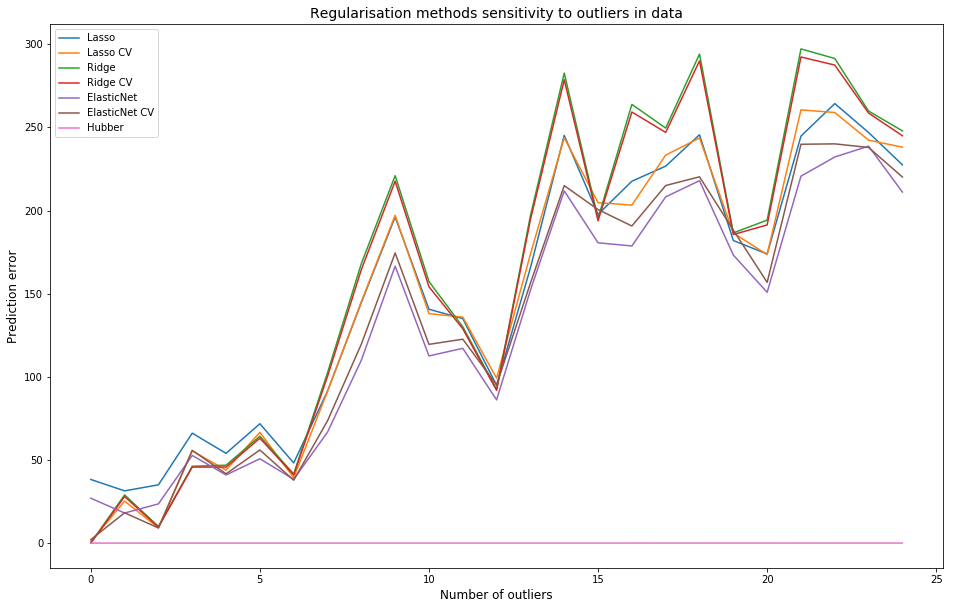

In [150]:
plt.figure(figsize=(16,10))
for name in modelNames:
    plt.plot(x, errors[name], label = name)
plt.title("Regularisation methods sensitivity to outliers in data", fontsize=14)
plt.xlabel("Number of outliers", fontsize=12)
plt.ylabel("Prediction error", fontsize=12)
_ = plt.legend()

Получите аналитическое решение задачи
$$ \min_w \|Xw - y\|^2_2 + \| \lambda \odot w \|^2_2, $$
где $\lambda$ - вектор такой же размерности, что и $w$, $\odot$ означает поэлементное умножение двух векторов

Решение:
* Необходимо найти градиент функционала
* Приравнять градиент к нулю

Функционал в данной задаче равен
$$ F = \|Xw - y\|^2_2 + \| \lambda \odot w \|^2_2 $$
И его градиент равен
$$ \nabla F = 2X^T(Xw-y) + 2\lambda \odot \lambda \odot w $$
Если $ \lambda \odot \lambda \equiv \lambda^2 $ то:
$$ \nabla F = 2X^T(Xw-y) + 2\lambda^2 \odot w $$
    
$$ \nabla F = 0 \Rightarrow $$ 
$$ 2X^T(Xw-y) + 2\lambda^2 \odot w = 0 \Rightarrow $$ 
$$ 2X^TXw - 2X^Ty + 2 \lambda^2 \odot w = 0 \Rightarrow $$
$$ (X^TX \odot \lambda^{-2})w - (X^Ty \odot \lambda^{-2}) + w = 0 \Rightarrow $$
$$ w(I_n + X^TX \odot \lambda^{-2}) = X^Ty \odot \lambda^{-2} $$

Отсюда:
$$ w = (I_n + X^TX \odot \lambda^{-2})^{-1} X^Ty \odot \lambda^{-2} $$

Где $ \lambda^{-2} \equiv \lambda^{-1} \odot \lambda^{-1} $, а $ v \odot \lambda^{-1} $ - поэлеметное деление вектора $v$ на вектор $\lambda$